# Linear Regression Exploration

I am walking through this again with fresh eyes to see if I can get a better score than when I first submitted this in the kaggle competition.
<hr>

These are my dependencies; the first four are for manipulating and plotting the data. I don't want to use seaborn, but it's really handy for heatmaps and pairplots which I may need later on.

The rest are for the linear regression modeling. I should probably take a look at a few other models (most notably Gradient Boost and Adaboost), but can add those later on.

In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder

## 1. Reading and cleaning data

I need to get rid of features where there are just too many null values. These don't help with predicting prices; they are noise (at least that is my assumption).

In [155]:
df = pd.read_csv('../data/train.csv')
df.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [156]:
df.shape

(2051, 81)

In [157]:
df.isnull().sum()[df.isnull().sum() > 0]

Lot Frontage       330
Alley             1911
Mas Vnr Type        22
Mas Vnr Area        22
Bsmt Qual           55
Bsmt Cond           55
Bsmt Exposure       58
BsmtFin Type 1      55
BsmtFin SF 1         1
BsmtFin Type 2      56
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
Bsmt Full Bath       2
Bsmt Half Bath       2
Fireplace Qu      1000
Garage Type        113
Garage Yr Blt      114
Garage Finish      114
Garage Cars          1
Garage Area          1
Garage Qual        114
Garage Cond        114
Pool QC           2042
Fence             1651
Misc Feature      1986
dtype: int64

After some analysis, I am going to fill these values with NA for now, can always drop these later on...

In [158]:
df['Fireplace Qu'].fillna("NA", inplace=True)
df['Pool QC'].fillna("NA", inplace=True)

I want to drop features with 1000ish missing values. This will get the column values that I will want to drop

In [159]:
columns_to_drop = df.isnull().sum()[df.isnull().sum() > 330].index.tolist()

In [160]:
df.drop(columns=columns_to_drop, inplace=True)

In [161]:
df.shape

(2051, 78)

I will take another look at the features with null values and see how I can fill these in.

In [162]:
df.isnull().sum()[df.isnull().sum() > 0]

Lot Frontage      330
Mas Vnr Type       22
Mas Vnr Area       22
Bsmt Qual          55
Bsmt Cond          55
Bsmt Exposure      58
BsmtFin Type 1     55
BsmtFin SF 1        1
BsmtFin Type 2     56
BsmtFin SF 2        1
Bsmt Unf SF         1
Total Bsmt SF       1
Bsmt Full Bath      2
Bsmt Half Bath      2
Garage Type       113
Garage Yr Blt     114
Garage Finish     114
Garage Cars         1
Garage Area         1
Garage Qual       114
Garage Cond       114
dtype: int64

In [163]:
columns_with_nulls = df.isnull().sum()[df.isnull().sum() > 0].index.tolist()

Taking a look at the types, I think I want to look at the object values and just default nan's in the float64 columns to 0 (I had looked at the values and this seemed sensible).

In [164]:
df[columns_with_nulls].dtypes

Lot Frontage      float64
Mas Vnr Type       object
Mas Vnr Area      float64
Bsmt Qual          object
Bsmt Cond          object
Bsmt Exposure      object
BsmtFin Type 1     object
BsmtFin SF 1      float64
BsmtFin Type 2     object
BsmtFin SF 2      float64
Bsmt Unf SF       float64
Total Bsmt SF     float64
Bsmt Full Bath    float64
Bsmt Half Bath    float64
Garage Type        object
Garage Yr Blt     float64
Garage Finish      object
Garage Cars       float64
Garage Area       float64
Garage Qual        object
Garage Cond        object
dtype: object

In [165]:
for col in df[columns_with_nulls].select_dtypes("float64").columns.tolist():
    df[col].fillna(0, inplace=True)

In [166]:
for col in df[columns_with_nulls].select_dtypes("object").columns:
    print(col)
    print()
    print(f"Null Count: {df[col].isnull().sum()}")
    print()
    print(df[col].sort_values().unique())
    [print() for _ in range(3)]

Mas Vnr Type

Null Count: 22

['BrkCmn' 'BrkFace' 'None' 'Stone' nan]



Bsmt Qual

Null Count: 55

['Ex' 'Fa' 'Gd' 'Po' 'TA' nan]



Bsmt Cond

Null Count: 55

['Ex' 'Fa' 'Gd' 'Po' 'TA' nan]



Bsmt Exposure

Null Count: 58

['Av' 'Gd' 'Mn' 'No' nan]



BsmtFin Type 1

Null Count: 55

['ALQ' 'BLQ' 'GLQ' 'LwQ' 'Rec' 'Unf' nan]



BsmtFin Type 2

Null Count: 56

['ALQ' 'BLQ' 'GLQ' 'LwQ' 'Rec' 'Unf' nan]



Garage Type

Null Count: 113

['2Types' 'Attchd' 'Basment' 'BuiltIn' 'CarPort' 'Detchd' nan]



Garage Finish

Null Count: 114

['Fin' 'RFn' 'Unf' nan]



Garage Qual

Null Count: 114

['Ex' 'Fa' 'Gd' 'Po' 'TA' nan]



Garage Cond

Null Count: 114

['Ex' 'Fa' 'Gd' 'Po' 'TA' nan]





It looks like some of these can have similar values and I can probably replace these values with numerical values after some exploratory data analysis.

In [167]:
df['Mas Vnr Type'].fillna("None", inplace=True)

In [168]:
string_cols = [
    'Bsmt Qual', 
    'Bsmt Cond', 
    'Garage Qual', 
    'Garage Cond', 
    'Garage Finish', 
    'Garage Type', 
    'Bsmt Exposure',
    'BsmtFin Type 1',
    'BsmtFin Type 2'
]

for val in string_cols:
    df[val].fillna("NA", inplace=True)

In [169]:
df.isnull().sum()[df.isnull().sum() > 0]

Series([], dtype: int64)

Going to check for out of bound values now...

In [170]:
set(df.dtypes.values)

{dtype('int64'), dtype('float64'), dtype('O')}

Going to see if I can cast the floats to integers instead.

I am going to set these in advance because they inherently categorical, it makes more sense to do this now than to label encode them in a strange way.

In [171]:
for rating_col in ['Exter Qual', 'Exter Cond','Bsmt Qual', 'Bsmt Cond','Heating QC', 'Garage Qual', 'Garage Cond']:
    df[rating_col] = df[rating_col].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA': 0})

In [172]:
df.select_dtypes("float64")[df.select_dtypes("float64").applymap(lambda x: x.is_integer()) == False].count()

Lot Frontage      0
Mas Vnr Area      0
BsmtFin SF 1      0
BsmtFin SF 2      0
Bsmt Unf SF       0
Total Bsmt SF     0
Bsmt Full Bath    0
Bsmt Half Bath    0
Garage Yr Blt     0
Garage Cars       0
Garage Area       0
dtype: int64

In [173]:
for col in df.select_dtypes("float64").columns.tolist():
    df[col] = df[col].astype("int64")

In [174]:
for col in df.select_dtypes("int64").columns.tolist():
    print(f"Min of {col}: {df[col].min()}")
    print(f"Max of {col}: {df[col].max()}")
    [print() for _ in range(3)]

Min of Id: 1
Max of Id: 2930



Min of PID: 526301100
Max of PID: 924152030



Min of MS SubClass: 20
Max of MS SubClass: 190



Min of Lot Frontage: 0
Max of Lot Frontage: 313



Min of Lot Area: 1300
Max of Lot Area: 159000



Min of Overall Qual: 1
Max of Overall Qual: 10



Min of Overall Cond: 1
Max of Overall Cond: 9



Min of Year Built: 1872
Max of Year Built: 2010



Min of Year Remod/Add: 1950
Max of Year Remod/Add: 2010



Min of Mas Vnr Area: 0
Max of Mas Vnr Area: 1600



Min of Exter Qual: 2
Max of Exter Qual: 5



Min of Exter Cond: 1
Max of Exter Cond: 5



Min of Bsmt Qual: 0
Max of Bsmt Qual: 5



Min of Bsmt Cond: 0
Max of Bsmt Cond: 5



Min of BsmtFin SF 1: 0
Max of BsmtFin SF 1: 5644



Min of BsmtFin SF 2: 0
Max of BsmtFin SF 2: 1474



Min of Bsmt Unf SF: 0
Max of Bsmt Unf SF: 2336



Min of Total Bsmt SF: 0
Max of Total Bsmt SF: 6110



Min of Heating QC: 1
Max of Heating QC: 5



Min of 1st Flr SF: 334
Max of 1st Flr SF: 5095



Min of 2nd Flr SF: 0
Max of 2nd

Going to drop row where the "Garage Yr Blt" value is greater than 2010.

In [175]:
df.drop(df[df['Garage Yr Blt'] > 2010].index, inplace=True)

Going to also drop "Id" and "PID" as these are not really helpful (I think)

In [176]:
df.drop(columns=["Id","PID"], inplace=True)

Going to drop an observation where the remodel year happens before the year built:

In [177]:
df.drop(df[df['Year Built'] > df['Year Remod/Add']].index, inplace=True)

## 2. Feature Engineering and Exploration

Now I am going to look at some features and see how they may impact the sales price. Going to also engineer some along the way to tease out some linear relationships.

According to the [data dictionary](https://www.kaggle.com/c/dsi-us-5-project-2-regression-challenge/data), the "YearRemodAdd" will use the 'same ... construction date if no remodeling or additions'. These means we can identify houses that haven't been remodeled.

In [178]:
df["Remodeled"] = 0

In [179]:
df[df['Year Built'] == df['Year Remod/Add']].shape

(1101, 77)

Going to add up the total area of the houses as a feature.

In [180]:
def add_up_square_feet(data_frame):
    # Set an initital value
    data_frame["total_square_feet"] = 0

    # Add up the values from the other columns minus the total column
    for col in [col for col in data_frame.columns if " SF" in col]:
        data_frame["total_square_feet"] += data_frame[col]
        

# retrieve the first 5 columns
add_up_square_feet(df)


df["total_square_feet"].head()

0    2973
1    4022
2    3223
3    2312
4    2856
Name: total_square_feet, dtype: int64

In [181]:
df.loc[df['Year Built'] < df['Year Remod/Add'], "Remodeled"] = 1

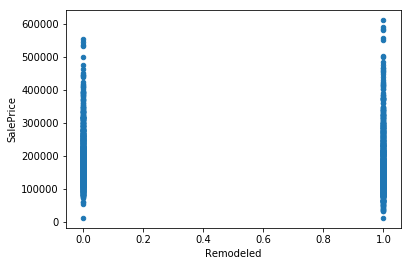

In [182]:
df[["Remodeled","SalePrice"]].plot(kind="scatter", x="Remodeled",y="SalePrice")

I am going to square the year values so that if there are any linear relationships, they should be stronger

In [183]:
yr_columns = ['Year Built','Yr Sold','Year Remod/Add','Garage Yr Blt']
df[yr_columns] =  df[yr_columns].applymap(lambda x: x**2)

Going to take a look at the object columns and see if I can reengineer them into something a but more usable.

In [184]:
df = pd.get_dummies(df)
# label_encoder_dict = {}

# for col in df.select_dtypes('object').columns.tolist():
#     le = LabelEncoder()
#     le.fit(df[col].unique())
#     df[col] = le.transform(df[col])
#     label_encoder_dict[f"{col}_string"] = {
#         "original": df[col].unique(), 
#         "transformed": le.classes_
#     }
#     df.rename(columns={f"{col}":f"{col}_string"}, inplace=True)

In [185]:
# string_columns_for_plotting = [col for col in df.columns if "_string" in col]

# for col in string_columns_for_plotting:
#     print(col)
#     inner_le = label_encoder_dict[col]
#     print(inner_le)
#     df.plot(kind="scatter", x=col, y="SalePrice")
#     plt.show()

In [186]:
set(df.dtypes.values)

{dtype('uint8'), dtype('int64')}

In [187]:
# https://stackoverflow.com/questions/34896455/how-to-do-pearson-correlation-of-selected-columns-of-a-pandas-data-frame
sp_corr = df[df.columns[1:]].corr()['SalePrice'][:-1]

In [188]:
print(sp_corr.sort_values().to_string())

Kitchen Qual_TA        -0.540624
Fireplace Qu_NA        -0.485864
Garage Finish_Unf      -0.431945
Mas Vnr Type_None      -0.411777
Garage Type_Detchd     -0.370128
Foundation_CBlock      -0.355206
Lot Shape_Reg          -0.305774
Bsmt Exposure_No       -0.292739
MS Zoning_RM           -0.281780
Central Air_N          -0.277293
Paved Drive_N          -0.273520
Roof Style_Gable       -0.248694
Garage Type_NA         -0.230908
Garage Finish_NA       -0.230772
Foundation_BrkTil      -0.229745
Neighborhood_OldTown   -0.208249
Electrical_FuseA       -0.201096
House Style_1.5Fin     -0.195645
Exterior 1st_Wd Sdng   -0.191547
Neighborhood_NAmes     -0.189182
Neighborhood_IDOTRR    -0.189175
Neighborhood_Edwards   -0.175998
Exterior 2nd_Wd Sdng   -0.172783
BsmtFin Type 1_NA      -0.157326
Kitchen Qual_Fa        -0.154822
BsmtFin Type 2_NA      -0.152079
BsmtFin Type 1_Rec     -0.150761
Bsmt Exposure_NA       -0.150279
Exterior 1st_MetalSd   -0.149620
Exterior 2nd_MetalSd   -0.139108
Enclosed P

In [691]:
most_correlated = sp_corr[ (sp_corr > .23)]
most_correlated.sort_values()

MS Zoning_RL            0.231218
Fireplace Qu_Ex         0.234680
2nd Flr SF              0.249112
Electrical_SBrkr        0.253927
Neighborhood_StoneBr    0.257149
Mas Vnr Type_BrkFace    0.258302
Neighborhood_NoRidge    0.263581
Roof Style_Hip          0.264575
Garage Cond             0.264935
Lot Shape_IR1           0.272993
Central Air_Y           0.277293
Half Bath               0.283653
Bsmt Full Bath          0.283835
Garage Yr Blt           0.284933
Garage Qual             0.285197
Paved Drive_Y           0.289101
Lot Area                0.296787
Kitchen Qual_Gd         0.306763
Mas Vnr Type_Stone      0.310331
Wood Deck SF            0.326399
Open Porch SF           0.334012
Exterior 2nd_VinylSd    0.337071
Exterior 1st_VinylSd    0.341660
Sale Type_New           0.357472
Garage Type_Attchd      0.357559
Bsmt Exposure_Gd        0.377386
Fireplace Qu_Gd         0.384329
Garage Finish_Fin       0.423513
BsmtFin SF 1            0.423922
Neighborhood_NridgHt    0.448964
Heating QC

In [692]:
features = most_correlated.index.tolist()
features.append("total_square_feet")

# for col in features:
#     if col!= 'SalePrice':
#         plt.figure(figsize=(12,12))
#         df.plot(kind="scatter", x=col, y="SalePrice")

## 3. Modeling

This is where the fun begins... I think the features above are the best features. Will try a few things out to see how I can lower the RMSE.

In [695]:
features_to_remove = [
    'SalePrice',
]

for feat in features:
    if "SF" in feat:
        features.remove(feat)
    if feat in features_to_remove:
        features.remove(feat)

features = list(set(features))        
        
print(features)    
    
X = df[features]
y = df['SalePrice']

['Electrical_SBrkr', 'Roof Style_Hip', 'Foundation_PConc', 'Full Bath', 'Fireplaces', 'Garage Finish_Fin', 'Garage Yr Blt', 'Mas Vnr Area', 'Exterior 2nd_VinylSd', 'Neighborhood_NridgHt', 'Bsmt Qual', 'Kitchen Qual_Ex', 'Half Bath', 'Mas Vnr Type_Stone', 'Kitchen Qual_Gd', 'Exterior 1st_VinylSd', 'Bsmt Exposure_Gd', 'Lot Area', 'Garage Qual', 'Neighborhood_StoneBr', 'Paved Drive_Y', 'MS Zoning_RL', 'Sale Type_New', 'Garage Area', 'Gr Liv Area', 'total_square_feet', 'Year Built', 'Fireplace Qu_Ex', 'Heating QC', 'Mas Vnr Type_BrkFace', 'Bsmt Full Bath', 'Garage Cars', 'Lot Shape_IR1', 'TotRms AbvGrd', 'Garage Type_Attchd', 'Central Air_Y', 'Overall Qual', 'Neighborhood_NoRidge', 'Fireplace Qu_Gd', 'BsmtFin Type 1_GLQ', 'Exter Qual', 'Year Remod/Add', 'Garage Cond']


In [702]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [703]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
lr.score(X_train_scaled, y_train)

0.8649021873817335

In [704]:
mean_squared_error(y_train, lr.predict(X_train_scaled))

838270264.7012244

In [705]:
lr.score(X_test_scaled, y_test)

0.8935015713186316

In [706]:
mean_squared_error(y_train, lr.predict(X_train_scaled))

838270264.7012244

In [707]:
rf = RandomForestRegressor()
rf.fit(X_train_scaled, y_train)
rf.score(X_train_scaled, y_train)

0.9789480867662776

In [708]:
rf.score(X_test_scaled, y_test)

0.906485536650376

In [709]:
{feature:rf.feature_importances_[i] for i, feature in enumerate(features)}

{'Electrical_SBrkr': 0.0003678840144068601,
 'Roof Style_Hip': 0.0006676630775544616,
 'Foundation_PConc': 0.0009513129675503745,
 'Full Bath': 0.006879062375665432,
 'Fireplaces': 0.005737932493705763,
 'Garage Finish_Fin': 0.0012022558097034082,
 'Garage Yr Blt': 0.00520431136238555,
 'Mas Vnr Area': 0.0073144182745368365,
 'Exterior 2nd_VinylSd': 0.0005144105259261942,
 'Neighborhood_NridgHt': 0.0001971269752082509,
 'Bsmt Qual': 0.005510988228145439,
 'Kitchen Qual_Ex': 0.007314134953688841,
 'Half Bath': 0.0015866303419199163,
 'Mas Vnr Type_Stone': 0.0006493478030571822,
 'Kitchen Qual_Gd': 0.002776107449905685,
 'Exterior 1st_VinylSd': 0.0005634153104550824,
 'Bsmt Exposure_Gd': 0.0010040308700866956,
 'Lot Area': 0.021264061129361245,
 'Garage Qual': 0.0013727826365087393,
 'Neighborhood_StoneBr': 0.0038271386287922217,
 'Paved Drive_Y': 0.0008636238456739475,
 'MS Zoning_RL': 0.001159385340907274,
 'Sale Type_New': 0.0016700376562898533,
 'Garage Area': 0.013389039225272653,
 

In [710]:
mean_squared_error(y_train, rf.predict(X_train_scaled))

130625304.26575927

In [711]:
mean_squared_error(y_test, rf.predict(X_test_scaled))

717930481.1054369

In [712]:
clf = Lasso(alpha=.05,normalize=True, max_iter=1e5)
clf.fit(X_train_scaled,y_train)
clf.score(X_train_scaled,y_train)

0.8649020207405568

In [713]:
clf.score(X_test_scaled,y_test)

0.8935426665910036

In [714]:
mean_squared_error(y_test, clf.predict(X_test_scaled))

817295655.1734319

In [715]:
rr = Ridge(alpha=1,max_iter=1e5)
rr.fit(X_train_scaled,y_train)
rr.score(X_train_scaled,y_train)

0.8649018511584986

In [716]:
rr.score(X_test_scaled,y_test)

0.8935558457324112

In [717]:
mean_squared_error(y_test, rr.predict(X_test_scaled))

817194476.093827

In [720]:
en = ElasticNet(alpha=1,max_iter=1e5)
en.fit(X_train_scaled,y_train)
en.score(X_train_scaled,y_train)

0.8555153452508185

In [721]:
en.score(X_test_scaled,y_test)

0.8849751199296823

In [722]:
mean_squared_error(y_test, en.predict(X_test_scaled))

883070538.2892028

In [723]:
gb = GradientBoostingRegressor(max_depth= 5, n_estimators=100, learning_rate=.05)
gb.fit(X_train_scaled,y_train)
gb.score(X_train_scaled,y_train)

0.9728117072724128

In [724]:
gb.score(X_test_scaled,y_test)

0.9414284657504846

In [725]:
mean_squared_error(y_test, gb.predict(X_test_scaled))

449666161.32548565

In [726]:
from xgboost.sklearn import XGBRegressor

xgb = XGBRegressor(max_depth= 5, n_estimators=100)
xgb.fit(X_train_scaled,y_train)
xgb.score(X_train_scaled,y_train)

0.9802080058852836

In [727]:
xgb.score(X_test_scaled,y_test)

0.9349307398173201

In [728]:
mean_squared_error(y_test, xgb.predict(X_test_scaled))

499550589.2331473

In [729]:
parameters = {
    'n_estimators': [600],
    'max_depth': [2],
    'gamma': [0]
}

gscv = GridSearchCV(xgb, parameters, cv=5, verbose=1, n_jobs=-1)
gscv.fit(X_train_scaled,y_train)
gscv.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.9s finished


{'gamma': 0, 'max_depth': 2, 'n_estimators': 600}

In [730]:
gscv.score(X_train_scaled,y_train)

0.9643387268420495

In [731]:
gscv.score(X_test_scaled,y_test)

0.9468231383409403

In [732]:
mean_squared_error(y_test, gscv.predict(X_test_scaled))

408250109.2032352

In [733]:
{feature:gscv.best_estimator_.feature_importances_[i] for i, feature in enumerate(features)}

{'Electrical_SBrkr': 0.00057110225,
 'Roof Style_Hip': 0.0017133066,
 'Foundation_PConc': 0.00513992,
 'Full Bath': 0.010850943,
 'Fireplaces': 0.03083952,
 'Garage Finish_Fin': 0.0068532266,
 'Garage Yr Blt': 0.040548258,
 'Mas Vnr Area': 0.03597944,
 'Exterior 2nd_VinylSd': 0.0039977157,
 'Neighborhood_NridgHt': 0.0028555111,
 'Bsmt Qual': 0.010850943,
 'Kitchen Qual_Ex': 0.0034266133,
 'Half Bath': 0.017133066,
 'Mas Vnr Type_Stone': 0.0011422045,
 'Kitchen Qual_Gd': 0.0068532266,
 'Exterior 1st_VinylSd': 0.0011422045,
 'Bsmt Exposure_Gd': 0.011422045,
 'Lot Area': 0.109651625,
 'Garage Qual': 0.0062821247,
 'Neighborhood_StoneBr': 0.007424329,
 'Paved Drive_Y': 0.002284409,
 'MS Zoning_RL': 0.008566533,
 'Sale Type_New': 0.009137636,
 'Garage Area': 0.05596802,
 'Gr Liv Area': 0.16504854,
 'total_square_feet': 0.15933752,
 'Year Built': 0.068532266,
 'Fireplace Qu_Ex': 0.0034266133,
 'Heating QC': 0.011422045,
 'Mas Vnr Type_BrkFace': 0.0028555111,
 'Bsmt Full Bath': 0.021130782,
 

In [734]:
ab = AdaBoostRegressor()
ab.fit(X_train_scaled,y_train)
ab.score(X_train_scaled,y_train)

0.87530653318746

In [735]:
ab.score(X_test_scaled,y_test)

0.8730994945144182

In [736]:
mean_squared_error(y_test, ab.predict(X_test_scaled))

974242247.5886798

In [737]:
# Plot predictions and how far off you are HERE

## Submit to Kaggle

In [738]:
# https://www.kaggle.com/dansbecker/submitting-from-a-kernel
# Read the test data
test = pd.read_csv('../data/test.csv')

add_up_square_feet(test)
    
# Replace null String values
test['Mas Vnr Type'].fillna("None", inplace=True)

for rating_col in ['Exter Qual', 'Exter Cond','Bsmt Qual', 'Bsmt Cond','Heating QC', 'Garage Qual', 'Garage Cond']:
    test[rating_col] = test[rating_col].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA': 0})

# Zero out numbers
for col in test.select_dtypes("float64").columns.tolist():
    test[col].fillna(0, inplace=True)

for col in test.select_dtypes("float64").columns.tolist():
    test[col] = test[col].astype("int64")    

test[yr_columns] =  test[yr_columns].applymap(lambda x: x**2)    
    
for val in string_cols:
    test[val].fillna("NA", inplace=True)

for col in test.select_dtypes('object').columns.tolist():
    test[col].fillna("NA", inplace=True)
#     test.rename(columns={f"{col}":f"{col}_string"}, inplace=True)        
 
# new_le = LabelEncoder()

# for col in test[features].select_dtypes('object').columns.tolist():
#     new_le.fit(test[col].unique())
#     test[col] = new_le.transform(test[col])


test = pd.get_dummies(test)
    
# Treat the test data in the same way as training data. In this case, pull same columns.
test_X = test[features]

scaled_test_X = ss.transform(test_X)

# Use the model to make predictions
predicted_prices = gscv.predict(scaled_test_X)
my_submission = pd.DataFrame({'Id': test.Id, 'SalePrice': predicted_prices})

file_name = '../submissions/new_kaggle.csv'
my_submission.to_csv(file_name, index=False)

In [739]:
import subprocess, webbrowser
result = subprocess.check_output(f'kaggle competitions submit -f {file_name} -m "uploading a new set" dsi-us-5-project-2-regression-challenge')
if result == b'Successfully submitted to DSI-US-5 Project 2 Regression Challenge':
    webbrowser.open("https://www.kaggle.com/c/dsi-us-5-project-2-regression-challenge/submissions?sortBy=privateScore&group=all&page=1&pageSize=20")
else:
    print(result)